# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()

train_scores = dict() ; test_scores  = dict() #to hold scores for viewing at the end

In [2]:
def grid_search_return_hp_dict(model, X_train_gs, y_train_gs, param_grid):
    """Run GridSearchCV on given model with defined param_grid, return best params as dict.
    Pre-assign sklearn model to variable. Pass param_grid as dict."""
    print(str(model).split(sep='(')[0], "grid search.")
    GS = GridSearchCV(model, param_grid, n_jobs=2)
    GS.fit(X_train_gs, y_train_gs)
    print(GS.best_params_)
    return(GS.best_params_)

def train_model(model, feature_set, hyperparameters, 
                grid_search = False):
    """Wrapper for training models with optional grid search and feature selection.
    Pass model with no brackets, ie Lars not Lars()
    If grid_search = True, hyperparameters is the hp ranges dictionary. Outputs trained model, best_hp
    If grid_search = False, hyperparameters is the hp dictionary. Outputs trained model"""
    X_train, X_test = X_train_main[feature_set], X_test_main[feature_set]
    
    if grid_search == True:
        best_hp = grid_search_return_hp_dict(model(),
                                             X_train, y_train, hyperparameters)
        print("Grid search complete!\nHyperparameters:\n", best_hp)
        training_model = model(**best_hp).fit(X_train, y_train)
        return training_model, best_hp

    if grid_search == False:
        print("No grid search\nHyperparameters:\n", hyperparameters)
        training_model = model(**hyperparameters).fit(X_train, y_train)
        return training_model

def produce_exp_vs_pred_df(features_list, model, codename): # generalise!
    """Pass features_list as a string"""
    pred_list = []
    for i in range(0, len(rdkit_features)):
        prediction = model.predict([rdkit_features[eval(features_list)].iloc[i]])
        pred_list.append(prediction)
    
    exp_vs_calc = pd.DataFrame(constants_first)
    exp_vs_calc['Predicted'] = pred_list
    exp_vs_calc.rename({'Kh_first':'Experimental'}, inplace=True, axis=1)
    exp_vs_calc.to_csv('models/RDKit_noVPAS/%s'%("expvcalc_" + str(model).split(sep='(')[0] + "_" + features_list[16:] + ".csv"))
    now = datetime.now()

    dt_string = now.strftime("_%d_%m_%Y_%H_%M_%S")
    filename = "models/RDKit_noVPAS/" + str(model).split(sep='(')[0] + "_" + features_list[16:] + dt_string + ".joblib"
    print(str(model).split(sep='(')[0], "run at:", now, ". Saving to", filename)
    
    joblib.dump(model, filename)
    return exp_vs_calc

def prediction_plot_scores(model_func, pred_df):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# RDkit descriptors
## Bringing in data and splitting it into parts

In [3]:
csv = pd.read_csv('rdkit_desc_noVPAS.csv') # contains non-VP/AS HLCs

print("Input Shape", csv.shape) #input shape

csv.dropna(axis=0, inplace=True)

print("Removed NaN, new shape", csv.shape) #removed NaN shape

species_names = csv.pop('0')
smiles_strings = csv.pop('SMILES')
constants_mean = csv.pop('Kh_mean')
constants_first = csv.pop('Kh_first')

varying_columns = csv[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

rdkit_features = csv.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

X_train_main, X_test_main, y_train, y_test = train_test_split(rdkit_features, constants_first, test_size=0.3)

Input Shape (1404, 34)
Removed NaN, new shape (1403, 34)


In [4]:
X_train_main

,wt,logp,fraction_sp3,ali_homo_rings,ali_hetero_rings,amide_bonds,aro_homo_rings,aro_hetero_rings,hba,hbd,tpsa,asph,ecce,isf,npr1,npr2,pmi1,pmi2,pmi3,rog,si
627,61.052764,-1.06260,1.000000,0,0,0,0,0,2,2,46.25,0.327472,0.947967,0.023044,0.318368,0.819236,35.551523,91.482506,111.668020,1.397814,5.186249e-01
144,28.031300,0.80220,0.000000,0,0,0,0,0,0,0,0.00,0.572881,0.985108,0.237475,0.171934,0.828066,3.486957,16.793787,20.280744,0.850246,2.640816e-14
535,138.068080,1.70922,0.250000,0,0,0,1,0,2,1,29.46,0.278255,0.918310,0.002223,0.395861,0.613500,275.973228,427.699462,697.146295,2.251518,6.319887e-02
607,117.057849,2.16790,0.000000,0,0,0,1,1,0,1,15.79,0.380183,0.956514,0.005538,0.291687,0.708313,127.896352,310.574566,438.470918,1.934628,2.614880e-11
1183,387.098584,4.23890,0.157895,0,0,1,2,1,6,0,65.82,0.678176,0.992427,0.000780,0.122835,0.955215,1225.332296,9528.703339,9975.452462,5.169666,1.825908e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,106.078250,2.30344,0.250000,0,0,0,1,0,0,0,0.00,0.262946,0.909360,0.003714,0.416011,0.600571,161.720714,233.467110,388.741700,1.921439,8.905638e-02
1248,185.968027,2.45770,0.142857,0,0,0,1,0,1,0,9.23,0.295335,0.927046,0.001930,0.374948,0.628843,325.794339,546.405095,868.905963,2.157421,4.714947e-02
194,120.093900,2.55742,0.333333,0,0,0,1,0,0,0,0.00,0.250999,0.917650,0.003366,0.397390,0.686522,203.950943,352.341565,513.226585,2.109289,2.034648e-01
1060,425.766472,8.58080,0.000000,0,0,0,2,0,0,0,0.00,0.366557,0.956686,0.000551,0.291122,0.881701,1599.769804,4845.116195,5495.192767,3.727087,3.657966e-01


In [5]:
for i in ['X_train_main', 'X_test_main', 'y_train', 'y_test']:
    #joblib.dump(exec('i'), "models/RDKit_noVPAS/%s.joblib"%i)
    eval('%s'%i).to_csv('models/RDKit_noVPAS/%s.csv'%i)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


## Feature Selection
Made aware of features selection methods in scikitlearn via https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

See also [scikit-learn docs](https://scikit-learn.org/stable/modules/feature_selection.html)
### Importances via 'dummy' GradientBoostingRegressor

In [6]:
fs_model = GradientBoostingRegressor()
fs_model.fit(X_train_main, y_train)
importances = pd.Series(fs_model.feature_importances_, index = X_train_main.columns)
top_15_features_model = list(importances.nlargest(15).index.values)

### Importances via 'dummy' LASSO model

In [7]:
dummy_lasso = Lasso(max_iter=10000, alpha=0.5)
selector = SelectFromModel(dummy_lasso).fit(X_train_main, y_train)
coefs = selector.estimator_.coef_
importances_lasso = pd.Series(coefs, index = X_train_main.columns)
top_15_features_lasso = list(importances_lasso.nlargest(15).index.values)

### SelectKBest using f_regression scoring function
F-test estimates degree of linear dependency

In [8]:
fs_kbest = SelectKBest(score_func= f_regression, k=15)
fit = fs_kbest.fit(X_train_main, y_train)
scores_f = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_kbest = list(scores_f.nlargest(15).index.values)

### SelectKBest using mutual_info_regression
Catch any statistical dependancy, but requires more samples than f_reg

In [9]:
fs_mut_info = SelectKBest(score_func= mutual_info_regression, k=15)
fit = fs_mut_info.fit(X_train_main, y_train)
scores_mutual = pd.Series(fit.scores_, index=X_train_main.columns)
top_15_features_mutual_info = list(scores_mutual.nlargest(15).index.values)

### Feature Selection results

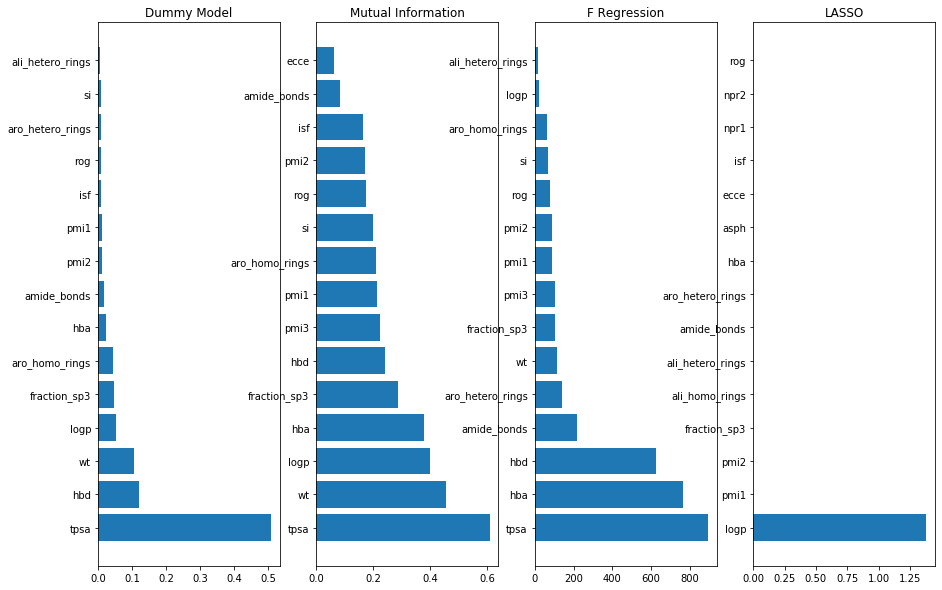

In [10]:
fig, imp_plot = plt.subplots(nrows=1, ncols=4, figsize=(15, 10))
imp_plot[0].barh(importances.nlargest(15).index.values, importances.nlargest(15))
imp_plot[0].set_title('Dummy Model')
imp_plot[1].barh(scores_mutual.nlargest(15).index.values, scores_mutual.nlargest(15))
imp_plot[1].set_title('Mutual Information')
imp_plot[2].barh(scores_f.nlargest(15).index.values, scores_f.nlargest(15))
imp_plot[2].set_title('F Regression')
imp_plot[3].barh(importances_lasso.nlargest(15).index.values, importances_lasso.nlargest(15))
imp_plot[3].set_title('LASSO')
plt.show()

## Exporting feature importances

In [11]:
joblib.dump(importances, "models/RDKit_noVPAS/model_importances.joblib")
joblib.dump(importances_lasso, "models/RDKit_noVPAS/lasso_importances.joblib")
joblib.dump(scores_f, "models/RDKit_noVPAS/freg_importances.joblib")
joblib.dump(scores_mutual, "models/RDKit_noVPAS/mutual_importances.joblib")

['models/RDKit_VPAS/mutual_importances.joblib']

## GradientBoosting
### Model-chosen features

In [12]:
gbr_param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [2, 4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
} #hyperparameters for each gbr grid search

In [13]:
gbr_model, gbr_hp = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=gbr_param_grid)

exp_vs_calc_gbr_model = produce_exp_vs_pred_df('top_15_features_model', gbr_model,
                                         "GradBoost, model-chosen features")

GradientBoostingRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 1000}
Grid search complete!
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-28 13:05:08.429223 . Saving to models/RDKit_VPAS/GradientBoostingRegressor_model_28_01_2020_13_05_08.joblib


### F-regression features

In [14]:
gbr_freg = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=gbr_hp)

exp_vs_calc_gbr_freg = produce_exp_vs_pred_df('top_15_features_kbest', gbr_freg,
                                                    "GradBoost, f_reg features")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-28 13:05:17.203535 . Saving to models/RDKit_VPAS/GradientBoostingRegressor_kbest_28_01_2020_13_05_17.joblib


### Mutual info features

In [15]:
gbr_mu = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=gbr_hp)

exp_vs_calc_gbr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', gbr_mu,
                                            "GradBoost, Mutual Info")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-28 13:05:26.390419 . Saving to models/RDKit_VPAS/GradientBoostingRegressor_mutual_info_28_01_2020_13_05_26.joblib


### LASSO features

In [16]:
gbr_lasso = train_model(model = GradientBoostingRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=gbr_hp)
exp_vs_calc_gbr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', gbr_lasso,
                                               "LASSO-features, GBR model")

No grid search
Hyperparameters:
 {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'max_features': 1.0, 'min_samples_leaf': 3, 'n_estimators': 1000}
GradientBoostingRegressor run at: 2020-01-28 13:05:35.040402 . Saving to models/RDKit_VPAS/GradientBoostingRegressor_lasso_28_01_2020_13_05_35.joblib


## Decision Tree
### Model-Chosen Features

In [17]:
dtr_param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'], #function measuring quality of a split
    'max_depth': [5, 10, 20] , # max depth of tree
    'max_features': [5, 10, 15], # N features to be considered when looking for split
    'max_leaf_nodes': [None, 10, 15, 20, 30], #grows tree with N nodes in best-first fashion
    'min_impurity_decrease': [0.0, 0.1],
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [1.0, 2, 3],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.5] , 
    'splitter': ['best', 'random']
} #hyperparameters for dtr gridsearch

In [18]:
dtr_model, dtr_hp = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=dtr_param_grid)


exp_vs_calc_dtr_model = produce_exp_vs_pred_df('top_15_features_model', dtr_model,
                                         "Decision Tree, model-chosen features")

DecisionTreeRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
Grid search complete!
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-28 13:09:02.943160 . Saving to models/RDKit_VPAS/DecisionTreeRegressor_model_28_01_2020_13_09_02.joblib


### F-regression features

In [19]:
dtr_freg = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=dtr_hp)
exp_vs_calc_dtr_freg = produce_exp_vs_pred_df('top_15_features_kbest', dtr_freg,
                                         "Decision Tree, freg features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-28 13:09:05.434227 . Saving to models/RDKit_VPAS/DecisionTreeRegressor_kbest_28_01_2020_13_09_05.joblib


### Mutual info features

In [20]:
dtr_mu = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=dtr_hp)
exp_vs_calc_dtr_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', dtr_mu,
                                         "Decision Tree, mutual info features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-28 13:09:07.928844 . Saving to models/RDKit_VPAS/DecisionTreeRegressor_mutual_info_28_01_2020_13_09_07.joblib


### LASSO features

In [21]:
dtr_lasso = train_model(model = DecisionTreeRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=dtr_hp)

exp_vs_calc_dtr_lasso = produce_exp_vs_pred_df('top_15_features_lasso', dtr_lasso,
                                         "Decision Tree, lasso features")

No grid search
Hyperparameters:
 {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 15, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}
DecisionTreeRegressor run at: 2020-01-28 13:09:10.321720 . Saving to models/RDKit_VPAS/DecisionTreeRegressor_lasso_28_01_2020_13_09_10.joblib


## AdaBoost Regressor
### Model Chosen Features

In [22]:
base_models = [ExtraTreesRegressor(n_estimators= 5,
                                   criterion= 'mse',
                                   max_features = 'log2'),
               RandomForestRegressor(n_estimators= 5,
                                     criterion= 'mse',
                                     max_features = 'sqrt',
                                     min_samples_split = 3),
              GradientBoostingRegressor(),
              DecisionTreeRegressor(),
              Lars(),
              ElasticNet()]

ada_param_grid = {
    'base_estimator' : base_models, 
    'learning_rate' : [0.3, 0.5, 0.8, 1], 
    'loss' : ['linear', 'square', 'exponential'], 
    'n_estimators' : [50, 100]
} #hyperparameters for adaboost gridsearch

In [23]:
ada_model, ada_hp = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=ada_param_grid)

exp_vs_calc_ada_model = produce_exp_vs_pred_df('top_15_features_model', ada_model,
                                               "AdaBoost, model features")

AdaBoostRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
Grid search complete!
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbos

### F-regression features

In [24]:
ada_freg = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_freg = produce_exp_vs_pred_df('top_15_features_kbest', ada_freg,
                                               "AdaBoost, freg features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-28 13:18:22.343841 . Saving to models/RDKit_VPAS/AdaBoostRegressor_kbest_28_01_2020_13_18_22.joblib


### Mutual info features

In [25]:
ada_mu = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', ada_mu,
                                               "AdaBoost, mutual info features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-28 13:20:01.084880 . Saving to models/RDKit_VPAS/AdaBoostRegressor_mutual_info_28_01_2020_13_20_01.joblib


### LASSO features

In [26]:
ada_lasso = train_model(model = AdaBoostRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=ada_hp)

exp_vs_calc_ada_lasso = produce_exp_vs_pred_df('top_15_features_lasso', ada_lasso,
                                               "AdaBoost, model features")

No grid search
Hyperparameters:
 {'base_estimator': ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='log2', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False), 'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
AdaBoostRegressor run at: 2020-01-28 13:21:40.127260 . Saving to models/RDKit_VPAS/AdaBoostRegressor_lasso_28_01_2020_13_21_40.joblib


## LASSO
### Model Chosen Features

In [27]:
lasso_param_grid = {
    'alpha':[0.2, 0.4, 0.6, 0.8],
    'max_iter':[1000, 5000, 10000, 50000],
    'selection':['cyclic', 'random']
}

In [28]:
lasso_model, lasso_hp = train_model(model = Lasso,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=lasso_param_grid)


exp_vs_calc_lasso_model = produce_exp_vs_pred_df('top_15_features_model', lasso_model,
                                                 "LASSO, model features")

Lasso grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Grid search complete!
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Lasso run at: 2020-01-28 13:21:47.136865 . Saving to models/RDKit_VPAS/Lasso_model_28_01_2020_13_21_47.joblib


### F-regression features

In [29]:
lasso_freg = train_model(model = Lasso,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_freg = produce_exp_vs_pred_df('top_15_features_kbest', lasso_freg,
                                                 "LASSO, f-reg features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Lasso run at: 2020-01-28 13:21:49.784890 . Saving to models/RDKit_VPAS/Lasso_kbest_28_01_2020_13_21_49.joblib


### Mutual info features

In [30]:
lasso_mu = train_model(model = Lasso,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lasso_mu,
                                                 "LASSO, mutual info features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Lasso run at: 2020-01-28 13:21:52.337901 . Saving to models/RDKit_VPAS/Lasso_mutual_info_28_01_2020_13_21_52.joblib


### LASSO Features

In [31]:
lasso_lasso = train_model(model = Lasso,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=lasso_hp)

exp_vs_calc_lasso_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lasso_lasso,
                                                 "LASSO, lasso features")

No grid search
Hyperparameters:
 {'alpha': 0.2, 'max_iter': 5000, 'selection': 'random'}
Lasso run at: 2020-01-28 13:21:54.781395 . Saving to models/RDKit_VPAS/Lasso_lasso_28_01_2020_13_21_54.joblib


## Random Forest Regressor
### Model Chosen Features

In [32]:
random_forest_param_grid = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]
}

In [33]:
random_forest_model, rfr_hp = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters=random_forest_param_grid)
exp_vs_calc_random_forest_model = produce_exp_vs_pred_df('top_15_features_model', random_forest_model,
                                                         "RandomForest, model features")

RandomForestRegressor grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
Grid search complete!
Hyperparameters:
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
RandomForestRegressor run at: 2020-01-28 15:09:33.279752 . Saving to models/RDKit_VPAS/RandomForestRegressor_model_28_01_2020_15_09_33.joblib


### F-regression features

In [34]:
random_forest_freg = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_freg = produce_exp_vs_pred_df('top_15_features_kbest', random_forest_freg,
                                                         "RandomForest, freg features")

No grid search
Hyperparameters:
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
RandomForestRegressor run at: 2020-01-28 15:10:24.767319 . Saving to models/RDKit_VPAS/RandomForestRegressor_kbest_28_01_2020_15_10_24.joblib


### Mutual info features

In [35]:
random_forest_mu = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', random_forest_mu,
                                                         "RandomForest, mutual info features")

No grid search
Hyperparameters:
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
RandomForestRegressor run at: 2020-01-28 15:11:16.637054 . Saving to models/RDKit_VPAS/RandomForestRegressor_mutual_info_28_01_2020_15_11_16.joblib


### LASSO features

In [36]:
random_forest_lasso = train_model(model = RandomForestRegressor,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters=rfr_hp)
exp_vs_calc_random_forest_lasso = produce_exp_vs_pred_df('top_15_features_lasso', random_forest_lasso,
                                                         "RandomForest, lasso features")

No grid search
Hyperparameters:
 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 600}
RandomForestRegressor run at: 2020-01-28 15:12:11.533489 . Saving to models/RDKit_VPAS/RandomForestRegressor_lasso_28_01_2020_15_12_11.joblib


## LARS - Least angle regression
### Model chosen features

In [37]:
lars_param_grid = {'n_nonzero_coefs': [0, 5, 10, 15]}

In [38]:
lars_model, lars_hp = train_model(model = Lars,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters= lars_param_grid)
exp_vs_calc_lars_model = produce_exp_vs_pred_df('top_15_features_model', lars_model, "LARS model features")

Lars grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_nonzero_coefs': 15}
Grid search complete!
Hyperparameters:
 {'n_nonzero_coefs': 15}
Lars run at: 2020-01-28 15:12:23.219168 . Saving to models/RDKit_VPAS/Lars_model_28_01_2020_15_12_23.joblib


### F-regression features

In [39]:
lars_freg = train_model(model = Lars,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters= lars_hp)
exp_vs_calc_lars_freg = produce_exp_vs_pred_df('top_15_features_kbest', lars_freg, "LARS freg features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 15}
Lars run at: 2020-01-28 15:12:25.033052 . Saving to models/RDKit_VPAS/Lars_kbest_28_01_2020_15_12_25.joblib


### Mutual info features

In [40]:
lars_mu = train_model(model = Lars,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters= lars_hp)

exp_vs_calc_lars_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', lars_mu, "LARS mutual info features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 15}
Lars run at: 2020-01-28 15:12:26.860902 . Saving to models/RDKit_VPAS/Lars_mutual_info_28_01_2020_15_12_26.joblib


### LASSO features

In [41]:
lars_lasso = train_model(model = Lars,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters= lars_hp)
exp_vs_calc_lars_lasso = produce_exp_vs_pred_df('top_15_features_lasso', lars_lasso, "LARS lasso features")

No grid search
Hyperparameters:
 {'n_nonzero_coefs': 15}
Lars run at: 2020-01-28 15:12:28.655696 . Saving to models/RDKit_VPAS/Lars_lasso_28_01_2020_15_12_28.joblib


## Elastic Net (linear regression l1 l2 norm regularization)
### Model chosen features

In [42]:
net_param_grid = {
    'alpha':[0.1, 0.3, 0.5, 0.8, 1.0],
    'l1_ratio':[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'fit_intercept':[True, False],
    'max_iter': [1000, 3000, 5000],
    'tol':[0.0001, 0.001, 0.01],
    'selection':['cyclic', 'random']
}

In [43]:
net_model, net_hp = train_model(model = ElasticNet,
           feature_set= top_15_features_model,
            grid_search=True,
           hyperparameters= net_param_grid)
exp_vs_calc_net_model = produce_exp_vs_pred_df('top_15_features_model', net_model, "ElasticNet model features")

ElasticNet grid search.


C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}
Grid search complete!
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}
ElasticNet run at: 2020-01-28 15:12:49.784211 . Saving to models/RDKit_VPAS/ElasticNet_model_28_01_2020_15_12_49.joblib


### F regression features

In [44]:
net_freg = train_model(model = ElasticNet,
           feature_set= top_15_features_kbest,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_freg = produce_exp_vs_pred_df('top_15_features_kbest', net_freg, "ElasticNet freg features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}
ElasticNet run at: 2020-01-28 15:12:51.597052 . Saving to models/RDKit_VPAS/ElasticNet_kbest_28_01_2020_15_12_51.joblib


### Mutual info features

In [45]:
net_mu = train_model(model = ElasticNet,
           feature_set= top_15_features_mutual_info,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_mu = produce_exp_vs_pred_df('top_15_features_mutual_info', net_mu, "ElasticNet mutual info features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}
ElasticNet run at: 2020-01-28 15:12:53.436970 . Saving to models/RDKit_VPAS/ElasticNet_mutual_info_28_01_2020_15_12_53.joblib


### LASSO features

In [46]:
net_lasso = train_model(model = ElasticNet,
           feature_set= top_15_features_lasso,
            grid_search=False,
           hyperparameters= net_hp)
exp_vs_calc_net_lasso = produce_exp_vs_pred_df('top_15_features_lasso', net_lasso, "ElasticNet lasso features")

No grid search
Hyperparameters:
 {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.8, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.01}
ElasticNet run at: 2020-01-28 15:12:55.265891 . Saving to models/RDKit_VPAS/ElasticNet_lasso_28_01_2020_15_12_55.joblib
